<a href="https://colab.research.google.com/github/vrnTEK/Deep-Learning/blob/master/Graded_Assignment_1_MNIST_classifier_using_numpy_and_python_without_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Creating MNIST Classifier using Numpy
###Goal is to use plain feed forward NNs without keras NN library but just numpy  (you can use keras only for image augmentation and getting training set and nothing else)
Following are the tasks that needs to be accomplished by the code:

1. The code should normalize the input as discussed in the class before training (scaling the input) 
2. The code should do mini batch gradient descent along with appropriate learning
3. The code should do dropout - try various dropout rates and pick the one which works well. (need not be same for all layers)
4. The code should initialize the random weights of network properly
5. The code should do basic image augmentations to supplement the training data (not testing data) using keras libraries
6. The code should use  3 or more layers for training (not 2 as in example ) - you have to tune and pick number of neurons in your layer and number of layers
7. The code will continue to use relu activation layer in right places like python code
8. The code should use appropriate learning rate (try out few to find out which one works) - you can use adaptive learning rates like different learning rates per epoch or per mini batch
9. The code should provide appropriate metrics, visualization,  testing and training accuracy etc.,. and plot the results and confusion matrix  (this is important)
10. The code should display top common errors images identified incorrectly
11. Extra points if you hit 99% test accuracy with these changes (very challenging given you are not using CNNs).


##Importing the Libraries required

In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
# Import PyDrive and associated libraries.
# This only needs to be done once per notebook.
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

####Importing MNIST Files from Google drive

In [2]:
# Download a file based on its file ID.
#https://drive.google.com/open?id=1Hcx5VtkGIjH9gU2O7_RLvKhBPgPgqHnX
#https://drive.google.com/open?id=16StDwyeRpgtWjmGK-k04iN8iHcSUhzhe
file_id1 = '1Hcx5VtkGIjH9gU2O7_RLvKhBPgPgqHnX'
downloaded = drive.CreateFile({'id': file_id1})
print('Downloaded content "{}"'.format(downloaded.GetContentString()))
downloaded.GetContentFile('mnist_train.csv')  
mnist_train = pd.read_csv('mnist_train.csv')
mnist_train.to_csv('mnist_train.csv')


file_id2 = '16StDwyeRpgtWjmGK-k04iN8iHcSUhzhe'
downloaded = drive.CreateFile({'id': file_id2})
print('Downloaded content "{}"'.format(downloaded.GetContentString()))
downloaded.GetContentFile('mnist_test.csv')  
mnist_test = pd.read_csv('mnist_test.csv')
mnist_test.to_csv('mnist_test.csv')

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [0]:
#redundant code to be deleted
#Loading the Mnist dataset from Keras dataset
#from tensorflow.examples.tutorials.mnist import input_data
#mnist = input_data.read_data_sets("MNIST_data/", one_hot=False)
#mnist = input_data.read_data_sets("MNIST_data/")

###Converting images to numpy array for easy calculation

Also checking the shape and dimentions in the numpy array defined

In [4]:
image_size = 28 # width and length
no_of_different_labels = 10 #  i.e. 0, 1, 2, 3, ..., 9
image_pixels = image_size * image_size

train_data = mnist_train.to_numpy()
test_data = mnist_test.to_numpy() 

test_data[test_data==255]
train_data.shape

(59999, 785)

In [0]:
#redundant code to be deleted. Use this for Keras dataset import directly
#Not use if internet is slow as it can take lot of time

#x_train = np.vstack([img.reshape(-1,) for img in mnist.train.images])
#y_train = mnist.train.labels

#x_test = np.vstack([img.reshape(-1,) for img in mnist.test.images])
#y_test = mnist.test.labels
#x_train.shape"""

In [0]:
#Redundant code to be deleted. Used this for storing the dataset to local RAM after importing
#Can be used if using TPU but this slows down in GPU later

#x_train = np.float32(mnist['x_train'][:])
#y_train = np.int32(np.array(MNIST_data['y_train'][:, 0])).reshape(-1, 1)
#x_test  = np.float32(MNIST_data['x_test'][:])
#y_test  = np.int32(np.array(MNIST_data['y_test'][:, 0])).reshape(-1, 1)"""

Now we have a 2 dimentional numpy array with 60000 rows with 784 (28 X 28) features of data in other two dimentions. We can now carry out the normalization of the data.

There is also an alternative method as well that we can follow:

The difference is that this will yield 3-dimentional array which needs to be reshaped into 2-D

  * from tensorflow.keras.datasets import mnist:
  * (x_train, y_train), (x_test, y_test) = mnist.load_data()
  * Converting training data to Numpy array
  * mnist_train = np.array(x_train)
  * mnist_trtarget = np.array(y_train)
  * Coverting test data to Numpy array
  * mnist_test = np.array(x_test)
  * mnist_tetarget = np.array(y_test)

###Prininting first record to check the values and range of features

In [7]:
"""import pprint
pp = pprint.PrettyPrinter(width=100, compact = True)
pp.pprint(mnistd_train[48000])"""

'import pprint\npp = pprint.PrettyPrinter(width=100, compact = True)\npp.pprint(mnistd_train[48000])'

###One Hot Encoding and data Transforming

As we can see from the above values that there are many zero values for pixels which are not activated this is something we need to avoid since weights dont update well for zero values also the value in array range from 0 to 255. we will divide the array by 255 and will add 0.01 to the result to ensure that we have no zero values and range can be between 0.01 to 0.99

In [0]:
fac = 0.99 / 255
train_imgs = np.asfarray(train_data[:, 1:]) * fac + 0.01
test_imgs = np.asfarray(test_data[:, 1:]) * fac + 0.01

#Separating training and test labels
train_labels = np.asfarray(train_data[:, :1])
test_labels = np.asfarray(test_data[:, :1])

###Encoding Output label as well with one hot encoding

Encoding Y training and Y test labels for entire dataset

In [9]:
# one-hot encoding
import numpy as np

lr = np.arange(10)

for label in range(10):
    one_hot = (lr==label).astype(np.int)
    print("label: ", label, " in one-hot representation: ", one_hot)

label:  0  in one-hot representation:  [1 0 0 0 0 0 0 0 0 0]
label:  1  in one-hot representation:  [0 1 0 0 0 0 0 0 0 0]
label:  2  in one-hot representation:  [0 0 1 0 0 0 0 0 0 0]
label:  3  in one-hot representation:  [0 0 0 1 0 0 0 0 0 0]
label:  4  in one-hot representation:  [0 0 0 0 1 0 0 0 0 0]
label:  5  in one-hot representation:  [0 0 0 0 0 1 0 0 0 0]
label:  6  in one-hot representation:  [0 0 0 0 0 0 1 0 0 0]
label:  7  in one-hot representation:  [0 0 0 0 0 0 0 1 0 0]
label:  8  in one-hot representation:  [0 0 0 0 0 0 0 0 1 0]
label:  9  in one-hot representation:  [0 0 0 0 0 0 0 0 0 1]


In [0]:
lr = np.arange(no_of_different_labels)

# transform labels into one hot representation
train_labels_one_hot = (lr==train_labels).astype(np.float)
test_labels_one_hot = (lr==test_labels).astype(np.float)

# we don't want zeroes and ones in the labels neither:
train_labels_one_hot[train_labels_one_hot==0] = 0.01
train_labels_one_hot[train_labels_one_hot==1] = 0.99
test_labels_one_hot[test_labels_one_hot==0] = 0.01
test_labels_one_hot[test_labels_one_hot==1] = 0.99

In [0]:
#Redundant Code To be deleted. Used it for training and test shuffle and split
#Multiple errors on data type conversion.
#Use above cell for encoding and transformation

#digits = 10
#examples = mnistar_train.shape[0]
#mnistar_train = mnistar_train.reshape(1, examples)
#Y_train = np.eye(digits)[mnistar_train.astype('int32')]
#Y_train = Y_train.T.reshape(digits, examples)

#digits = 10
#examples = mnistar_test.shape[0]
#mnistar_test = mnistar_test.reshape(1, examples)
#Y_test = np.eye(digits)[mnistar_test.astype('int32')]
#Y_test = Y_test.T.reshape(digits, examples)

# number of training set
#m = 55000
#m_test = X.shape[0] - m
#X_train, X_test = X[:m].T, X[m:].T
#Y_train, Y_test = Y_new[:, :m], Y_new[:, m:]

# shuffle training set
#shuffle_index = np.random.permutation(m)
#X_train, Y_train = X_train[:, shuffle_index], Y_train[:, shuffle_index]

#X_transpose = X_train[:].T #redundant code for checking the data orientation
#X_transpose.shape

###Displaying the output for training data 

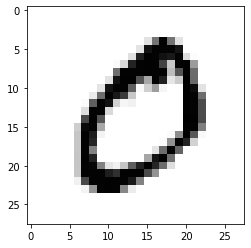

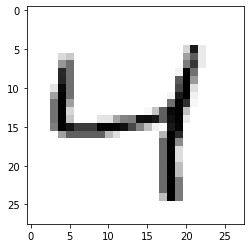

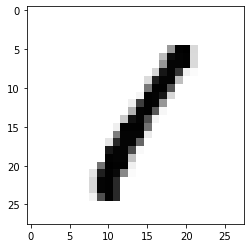

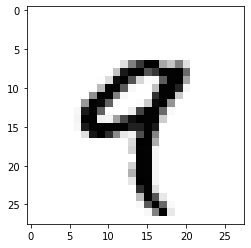

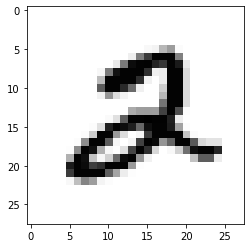

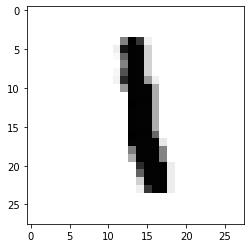

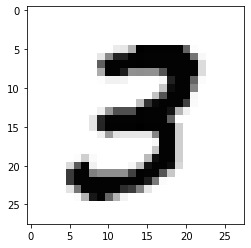

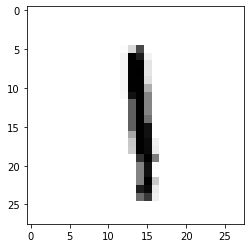

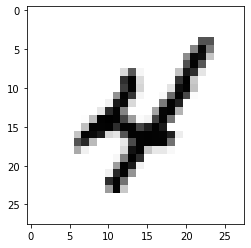

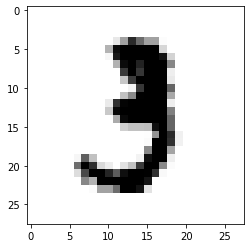

In [12]:
for i in range(10):
    img = train_imgs[i].reshape((28,28))
    plt.imshow(img, cmap="Greys")
    plt.show()

###Saving the data in a pickle file for quick access and caching of data in Local GPU RAM in Colab.

In [0]:
import pickle
#This is a Binary write (Check 'bw')
with open("pickled_mnist.pkl", "bw") as fh:
    data = (train_imgs, 
            test_imgs, 
            train_labels,
            test_labels,
            train_labels_one_hot,
            test_labels_one_hot)
    pickle.dump(data, fh)

In [0]:
import pickle

with open("pickled_mnist.pkl", "br") as fh:
    data = pickle.load(fh)

train_imgs = data[0]
test_imgs = data[1]
train_labels = data[2]
test_labels = data[3]
train_labels_one_hot = data[4]
test_labels_one_hot = data[5]

image_size = 28 # width and length
no_of_different_labels = 10 #  i.e. 0, 1, 2, 3, ..., 9
image_pixels = image_size * image_size

### Creating a Classifier Artificial Neural Network

####Creating the Sigmoid function class as defined in slides

In [0]:
@np.vectorize
def sigmoid(z):
    """
    sigmoid activation function.

    inputs: z
    outputs: sigmoid(z)
    """
    s = 1. / (1. + np.exp(-z))
    return s
activation_function = sigmoid

In [0]:
from scipy.special import expit as activation_function
from scipy.stats import truncnorm

def truncated_normal(mean=0, sd=1, low=0, upp=10):
    return truncnorm((low - mean) / sd,
                     (upp - mean) / sd, 
                     loc=mean, 
                     scale=sd)

####Simple Neural network creation with multiple Hidden layers and Epoch

In [0]:
class NeuralNetwork:
 
    def __init__(self, 
                 no_of_in_nodes, 
                 no_of_out_nodes, 
                 no_of_hidden_nodes,
                 learning_rate,
                 bias=None
                ):  

        self.no_of_in_nodes = no_of_in_nodes
        self.no_of_out_nodes = no_of_out_nodes
        
        self.no_of_hidden_nodes = no_of_hidden_nodes
            
        self.learning_rate = learning_rate 
        self.bias = bias
        self.create_weight_matrices()
    
        
    
    def create_weight_matrices(self):
        """ 
        A method to initialize the weight matrices 
        of the neural network with optional 
        bias nodes"""
        
        bias_node = 1 if self.bias else 0
        
        rad = 1 / np.sqrt(self.no_of_in_nodes + bias_node)
        X = truncated_normal(mean=0, sd=1, low=-rad, upp=rad)
        self.wih = X.rvs((self.no_of_hidden_nodes, 
                          self.no_of_in_nodes + bias_node))

        rad = 1 / np.sqrt(self.no_of_hidden_nodes + bias_node)
        X = truncated_normal(mean=0, 
                             sd=1, 
                             low=-rad, 
                             upp=rad)
        self.who = X.rvs((self.no_of_out_nodes, 
                          self.no_of_hidden_nodes + bias_node))
        
 
    def train_single(self, input_vector, target_vector):
        """
        input_vector and target_vector can be tuple, 
        list or ndarray
        """

        bias_node = 1 if self.bias else 0
        if self.bias:
            # adding bias node to the end of the inpuy_vector
            input_vector = np.concatenate( (input_vector, 
                                            [self.bias]) )
        
        output_vectors = []
        input_vector = np.array(input_vector, ndmin=2).T
        target_vector = np.array(target_vector, ndmin=2).T

        
        output_vector1 = np.dot(self.wih, 
                                input_vector)
        output_hidden = activation_function(output_vector1)
        
        if self.bias:
            output_hidden = np.concatenate((output_hidden, 
                                            [[self.bias]]) )

        
        output_vector2 = np.dot(self.who, 
                                output_hidden)
        output_network = activation_function(output_vector2)
        
        output_errors = target_vector - output_network
        # update the weights:
        tmp = output_errors * output_network * (1.0 - output_network)          
        tmp = self.learning_rate  * np.dot(tmp, 
                                           output_hidden.T) 
        self.who += tmp

        
        # calculate hidden errors:
        hidden_errors = np.dot(self.who.T, 
                               output_errors)
        # update the weights:
        tmp = hidden_errors * output_hidden * (1.0 - output_hidden)
        if self.bias:
            x = np.dot(tmp, input_vector.T)[:-1,:] 
        else:
            x = np.dot(tmp, input_vector.T)
        self.wih += self.learning_rate * x
        

    def train(self, data_array, 
              labels_one_hot_array,
              epochs=1,
              intermediate_results=False):
        intermediate_weights = []
        for epoch in range(epochs):  
            for i in range(len(data_array)):
                self.train_single(data_array[i], 
                                  labels_one_hot_array[i])
            if intermediate_results:
                intermediate_weights.append((self.wih.copy(), 
                                             self.who.copy()))
        return intermediate_weights      
        

        
    
    def run(self, input_vector):
        # input_vector can be tuple, list or ndarray
        
        if self.bias:
            # adding bias node to the end of the inpuy_vector
            input_vector = np.concatenate( (input_vector, 
                                            [self.bias]) )
        input_vector = np.array(input_vector, ndmin=2).T

        output_vector = np.dot(self.wih, 
                               input_vector)
        output_vector = activation_function(output_vector)
        
        if self.bias:
            output_vector = np.concatenate( (output_vector, 
                                             [[self.bias]]) )
            

        output_vector = np.dot(self.who, 
                               output_vector)
        output_vector = activation_function(output_vector)
    
        return output_vector
    
    
    def evaluate(self, data, labels):
        corrects, wrongs = 0, 0
        for i in range(len(data)):
            res = self.run(data[i])
            res_max = res.argmax()
            if res_max == labels[i]:
                corrects += 1
            else:
                wrongs += 1
        return corrects, wrongs

In [18]:
epochs = 12

feed_forward = NeuralNetwork(no_of_in_nodes=image_pixels, 
                        no_of_out_nodes=10, 
                        no_of_hidden_nodes=100,
                        learning_rate=0.1,
                        bias=None)

weights = feed_forward.train(train_imgs, 
                        train_labels_one_hot, 
                        epochs=epochs, 
                        intermediate_results=True) 
for epoch in range(epochs):  
    print("epoch: ", epoch)
    feed_forward.wih = weights[epoch][0]
    feed_forward.who = weights[epoch][1]
    corrects, wrongs = feed_forward.evaluate(train_imgs, 
                                        train_labels)
    print("accuracy train: ", corrects / ( corrects + wrongs))                   
    corrects, wrongs = feed_forward.evaluate(test_imgs, 
                                        test_labels)
    print("accuracy test: ", corrects / ( corrects + wrongs)) 

epoch:  0
accuracy train:  0.944049067484458
accuracy test:  0.942994299429943
epoch:  1
accuracy train:  0.9605993433223887
accuracy test:  0.9555955595559555
epoch:  2
accuracy train:  0.9655494258237637
accuracy test:  0.9581958195819582
epoch:  3
accuracy train:  0.9690494841580694
accuracy test:  0.9596959695969597
epoch:  4
accuracy train:  0.971899531658861
accuracy test:  0.9621962196219622
epoch:  5
accuracy train:  0.9715161919365323
accuracy test:  0.960996099609961
epoch:  6
accuracy train:  0.9737662294371573
accuracy test:  0.9613961396139614
epoch:  7
accuracy train:  0.9762496041600693
accuracy test:  0.9631963196319632
epoch:  8
accuracy train:  0.9761162686044768
accuracy test:  0.9633963396339634
epoch:  9
accuracy train:  0.9752995883264721
accuracy test:  0.9628962896289629
epoch:  10
accuracy train:  0.9773996233270554
accuracy test:  0.9622962296229624
epoch:  11
accuracy train:  0.9779329655494258
accuracy test:  0.963096309630963
